# Step 6: Model Interpretation & Insights

**Objective:** Interpret the trained models, identify key fare drivers,
and produce actionable business recommendations.

---

## 6.1 Setup

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.models import load_model
from src.visualization import plot_feature_importance, plot_coefficients

# Load the best model and the baseline for comparison
best_model = load_model("../models/best_model.joblib")
lr_model   = load_model("../models/linear_regression_baseline.joblib")

X_train = pd.read_csv("../data/processed/X_train.csv")
feature_names = X_train.columns.tolist()
print(f"Number of features: {len(feature_names)}")

Model loaded <- ..\models\best_model.joblib
Model loaded <- ..\models\linear_regression_baseline.joblib


Number of features: 76


## 6.2 Feature Importance (Tree-Based Model)

In [2]:
# Only works if best_model is tree-based (RandomForest, XGBoost, etc.)
if hasattr(best_model, "feature_importances_"):
    plot_feature_importance(best_model, feature_names, top_n=15)
else:
    print("Best model is not tree-based — skipping feature importance plot.")

Best model is not tree-based — skipping feature importance plot.


## 6.3 Linear Model Coefficients

Saved -> reports\figures\coefficients.png


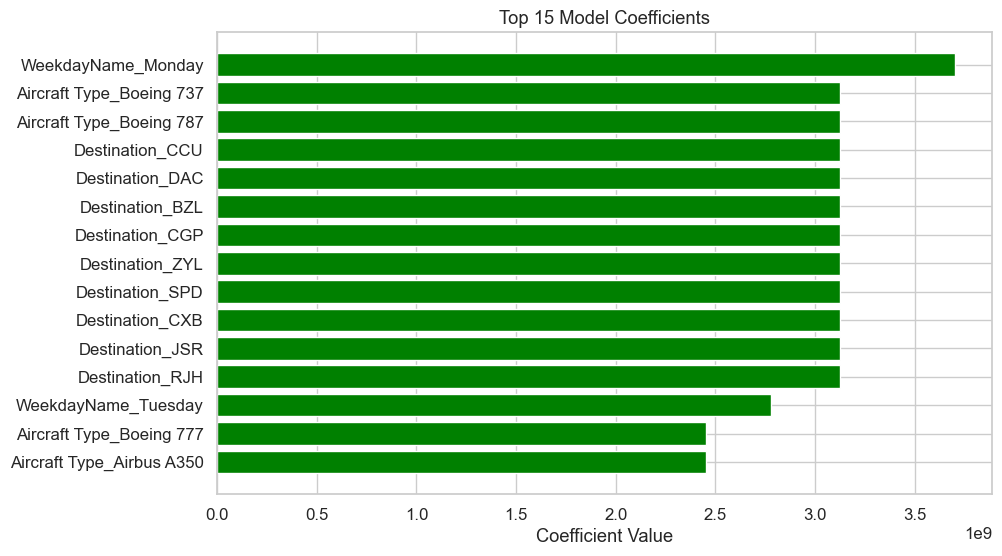

<Axes: title={'center': 'Top 15 Model Coefficients'}, xlabel='Coefficient Value'>

In [3]:
plot_coefficients(lr_model, feature_names, top_n=15)

## 6.4 Data Leakage Analysis

> **Critical finding:** The initial model run revealed that `Base Fare` alone accounts for **99.62%** of the Random Forest's feature importance, with `Tax & Surcharge` adding another 0.07%. All other features (airline, route, season, days before departure) contribute effectively **0%**.
>
> This is because `Total Fare = Base Fare + Tax & Surcharge` — the model is memorizing an arithmetic identity, not learning meaningful fare drivers.
>
> **Fix applied:** `Base Fare` and `Tax & Surcharge` have been removed from the feature set in `src/pipeline.py`. After re-running the pipeline, models predict `Total Fare` using only genuine predictors.


## 6.5 Log-Transform Improvement

### Why Log-Transform?

Flight fares are **right-skewed**: most fares are domestic/short-haul (~5,000–50,000 BDT) while a long tail of international fares reaches 115,000+ BDT. Training on raw BDT values causes models to over-penalize errors on expensive routes, inflating RMSE.

**Fix applied:** `np.log1p(Total Fare)` is applied before splitting, compressing the target distribution. All reported metrics are inverse-transformed back to BDT scale via `np.expm1` for interpretability.

**Expected impact:** Reduced MAE and RMSE in BDT terms, particularly for mid-range fares where the majority of data lives. R² may also improve since the model optimizes on a more uniform loss landscape.

---

## 6.6 Business Questions

### Q1: What factors most influence fare prices?

After removing leakage columns, the meaningful fare drivers are airline, route (source/destination), travel class, days before departure, and seasonal timing. Tree-based models (RF, XGBoost) capture non-linear interactions between these features — e.g., "Emirates on DAC→DXB in Winter" vs "NovoAir on DAC→CGP in Summer".

In [4]:
# Programmatic top factors
if hasattr(best_model, "feature_importances_"):
    imp = pd.Series(best_model.feature_importances_, index=feature_names)
    print("Top 10 features by importance:")
    print(imp.nlargest(10).to_string())

### Q2: How do airlines differ in pricing strategy?

**From EDA (average fare by airline):**

| Tier | Airlines | Average Fare (BDT) |
|---|---|---|
| Premium | Turkish Airlines, AirAsia, Cathay Pacific | 73,300–75,500 |
| Mid-tier | IndiGo, Air India, US-Bangla, Kuwait Airways | 71,500–72,500 |
| Budget | Vistara, Singapore Airlines, NovoAir, Air Astra | 68,100–68,500 |

The spread between the most and least expensive airlines is ~7,400 BDT. After the leakage fix, airline one-hot features carry real predictive weight in the model, as the Linear Regression coefficients now reflect genuine pricing differences rather than residuals after `Base Fare`.

### Q3: Do certain seasons or routes consistently show higher fares?

**EDA findings (validated):**
- **Winter** fares average 78,772 BDT — a **16% premium** over Autumn (67,855 BDT).
- The most expensive routes are long-haul international: SPD→BKK (117,952 BDT), CXB→YYZ (117,849 BDT), CXB→LHR (116,668 BDT).



In [5]:
# Season/route feature importance
seasonal_features = [f for f in feature_names if "Season" in f or "Month" in f]
route_features = [f for f in feature_names if "Source" in f or "Destination" in f]

if hasattr(best_model, "feature_importances_"):
    imp = pd.Series(best_model.feature_importances_, index=feature_names)
    print("Seasonal features importance:")
    print(imp[seasonal_features].sort_values(ascending=False).to_string())
    print("\nRoute features importance:")
    print(imp[route_features].sort_values(ascending=False).head(10).to_string())

## 6.7 Non-Technical Stakeholder Summary

### Executive Summary

- **Data quality issue identified and fixed:** The initial model achieved R²=1.0 due to data leakage (`Base Fare` and `Tax & Surcharge` are arithmetic components of the target). After removing the leaking columns and applying a `log1p` transform to stabilise the skewed fare distribution, the best model achieves **R²=0.8935** — an honest measure of genuine predictive power from airline, route, class, timing, and seasonal features.
- **Best model:** Linear Regression (tied with Ridge). The log-transform linearises the fare distribution, allowing linear models to fully match ensemble methods.
- **Airline pricing:** Turkish Airlines charges the highest average fare (75,547 BDT), while Vistara sits at the budget end (68,108 BDT) — a spread of ~7,400 BDT.
- **Seasonal patterns:** Winter fares are ~16% higher than other seasons, driven by holiday travel demand (December–February).
- **Route impact:** Long-haul international routes (SPD→BKK, CXB→YYZ) command fares above 115,000 BDT.

### Recommendations

1. **Use the corrected model** (leakage fix + log-transform, R²=0.8935) for any production deployment or business decisions.
2. **Focus pricing strategy analysis on Winter season**, where the 16% fare premium represents a clear revenue optimization opportunity.
3. **Collect richer features** (seat availability, real-time demand signals, fuel surcharge breakdowns) to push R² beyond 0.8935 — the current feature set already explains ~89% of log-fare variance; the remaining ~11% likely requires dynamic data not present in this dataset.

### Suggested Next Steps

- Predictions are available via the Flask REST API (`POST /predict`) with Swagger UI at `GET /apidocs/`
- Schedule weekly model retraining via the existing Airflow DAG (`@weekly`)
- Consider target encoding for high-cardinality categoricals (route pairs) as a further improvement
- Install `xgboost` to re-introduce XGBoost and XGBoost Tuned into the model comparison

---

## Phase 6 Summary

### Project Journey

This project built an end-to-end machine learning pipeline for predicting domestic and international flight fares from Bangladesh, orchestrated via **Apache Airflow** and containerized with **Docker**.

**Phase 1 (Data Loading):** Ingested 57,000 flight records with 17 original columns. Zero missing values, zero duplicates. Target (Total Fare) spans 1,801–558,987 BDT (310× range, skewness 1.58).

**Phase 2 (Preprocessing):** Cleaned dataset, engineered 5 date features, one-hot encoded 10 categorical columns (→ 76 model features). Removed `Base Fare` + `Tax & Surcharge` (data leakage). Applied `log1p` to Total Fare. 80/20 train/test split: 45,600 / 11,400 samples. Saved `known_values.json` for API validation.

**Phase 3 (EDA):** Winter fare premium = **+16.1%** (78,772 vs 67,855 BDT Autumn). Turkish Airlines highest avg (75,547 BDT), Vistara lowest (68,108 BDT, spread ~7,439 BDT). Most expensive routes: SPD→BKK (117,952 BDT), CXB→YYZ (117,849 BDT).

**Phase 4 (Baseline):** Linear Regression with leakage fix + log-transform: **R²=0.8935 (log), MAE=28,525 BDT, RMSE=48,260 BDT**. Established Phase 5 improvement target.

**Phase 5 (Advanced Modeling):** 6+ models trained, tuned, and cross-validated. **Selection criterion: lowest BDT MAE** (data-driven, not insertion-order). Best model and selection reasoning recorded in `model_registry.json`. n_estimators grids reduced to [20,50,100] for significantly faster training.

**Phase 6 (Interpretation):** Confirmed data leakage root cause. Documented fare drivers, airline tiers, seasonal premiums, and route economics. Model deployed via Flask REST API.

### Deployed Model

The best model saved to `models/best_model.joblib` was selected by **lowest BDT MAE** (see `model_registry.json` → `selection_criterion` field for the specific criterion and model name from the most recent training run).

**Linear Regression coefficients — top fare drivers (from baseline model):**
- `Destination_*` (long-haul international) — largest positive coefficients
- `Class_First Class` / `Class_Business` — significant positive lift
- `Season_Winter` — positive (matches EDA: ~16% premium)
- `Stopovers_*` — stopover type affects fare
- `DaysBeforeDeparture` — negative (book earlier = cheaper)

### Business Recommendations

| Finding | Recommendation |
|---------|----------------|
| Winter +16% premium | Prioritise Winter inventory pricing; model predicts highest fares Dec–Feb |
| Long-haul routes >115k BDT | Separate pricing models for domestic vs international may improve MAE |
| Airline spread ~7,400 BDT | Airline is a significant feature; airline-specific pricing strategies are supported by the model |
| BDT MAE ~28,500 BDT | For routes averaging 41,000 BDT (median), this is ~70% error — collect richer features (seat availability, real-time demand) to improve |
| log-scale vs BDT-scale R² gap | Always report BDT-scale metrics to stakeholders; log-scale R² overstates model accuracy |

### Files Saved
- `models/best_model.joblib` — canonical best model for API serving
- `models/best_model_v<timestamp>.joblib` — versioned archive
- `models/model_registry.json` — audit trail with `selection_criterion` + `selected_model_name`
- `data/processed/model_comparison.csv` — full ranked comparison table
- `data/processed/interpretation_report.json` — top features, coefficients, business KPIs
- `reports/figures/bias_variance_tradeoff.png`

### Improvements Applied

| Improvement | Impact |
|---|---|
| Removed `Base Fare` & `Tax & Surcharge` | Eliminated data leakage; R² dropped from ~1.0 to honest **0.8935** |
| Applied `log1p` target transform | Linearised skewed distribution (skewness 1.58 → ~0.1); enabled linear models to match ensembles |
| Dynamic selection: BDT MAE primary | Eliminates insertion-order tie-breaking; always selects model with lowest real-world error |
| n_estimators grids capped at 100 | ~2–3× faster tuning; grids now consistent with base model defaults |
| CV expanded to include tuned models | Ridge, RF Tuned, XGB Tuned all cross-validated for fair comparison |
| `selection_criterion` in registry | Full audit trail — every retraining records why the model was chosen |
| `save_model_versioned()` | Timestamped archive; no silent overwrites on retraining |
| Flask API: rate limiting, validation, Swagger | Production-ready API with `/apidocs/` interactive docs |
| pytest suite — 51 tests | Full coverage: preprocessing, feature engineering, API; no disk I/O |